In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tanlikesmath/the-oxfordiiit-pet-dataset")

print("Path to dataset files:", path)

100%|██████████| 1.48G/1.48G [01:08<00:00, 23.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/tanlikesmath/the-oxfordiiit-pet-dataset/versions/1


In [ ]:
print(path)


/root/.cache/kagglehub/datasets/tanlikesmath/the-oxfordiiit-pet-dataset/versions/1


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import os



In [ ]:
DATASET_PATH = path   # from kagglehub

IMAGE_DIR = os.path.join(DATASET_PATH, "images")
MASK_DIR  = os.path.join(DATASET_PATH, "annotations/trimaps")


In [ ]:
image_files = sorted(os.listdir(IMAGE_DIR))

print("Total images:", len(image_files))


Total images: 7394


In [ ]:
from tensorflow.keras import layers, models, Input

# --------------------------------
# BASIC BLOCKS
# --------------------------------

def double_conv_block(x, n_filters):
    x = layers.Conv2D(n_filters, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(n_filters, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    return x


def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    return f, p


def upsample_block(x, conv_features, n_filters):
    x = layers.Conv2DTranspose(n_filters, 3, strides=2, padding="same")(x)
    x = layers.concatenate([x, conv_features])
    x = double_conv_block(x, n_filters)
    return x


# --------------------------------
# BUILD U-NET
# --------------------------------

def build_unet(input_shape=(256, 256, 3)):

    inputs = Input(input_shape)

    # Encoder
    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)

    # Bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # Decoder
    u6 = upsample_block(bottleneck, f4, 512)
    u7 = upsample_block(u6, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)

    # Output layer
    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(u9)

    model = models.Model(inputs, outputs, name="U-Net")

    return model


In [ ]:
model = build_unet(input_shape=(256, 256, 3))
model.summary()


Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[

 Total params: 34,536,897 (131.75 MB)

 Trainable params: 34,525,121 (131.70 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [ ]:
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Create model
model = build_unet(input_shape=(256, 256, 3))
model.summary()


# ------------------------------
# DICE LOSS
# ------------------------------

def dice_loss(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    intersection = tf.reduce_sum(y_true_f * y_pred_f)

    return 1 - (2. * intersection + 1e-6) / (
        tf.reduce_sum(y_true_f) +
        tf.reduce_sum(y_pred_f) +
        1e-6
    )


# ------------------------------
# COMPILE
# ------------------------------

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=dice_loss,
    metrics=[
        "accuracy",
        tf.keras.metrics.MeanIoU(num_classes=2)
    ]
)

print("U-Net model ready ✓")


Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 256, 256,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_23[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 64, 64,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_24[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_6[

 Total params: 34,536,897 (131.75 MB)

 Trainable params: 34,525,121 (131.70 MB)

 Non-trainable params: 11,776 (46.00 KB)

U-Net model ready ✓


In [ ]:
model = build_unet(input_shape=(128, 128, 1))
model.summary()


Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 128, 128,  │        640 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_38[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 128, 128,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_39[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_8[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_40[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 64, 64,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_41[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_9[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_42[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 32, 32,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_43[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_10

 Total params: 34,535,745 (131.74 MB)

 Trainable params: 34,523,969 (131.70 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [ ]:
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

def dice_loss(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    intersection = tf.reduce_sum(y_true_f * y_pred_f)

    return 1 - (2. * intersection + 1e-6) / (
        tf.reduce_sum(y_true_f) +
        tf.reduce_sum(y_pred_f) +
        1e-6
    )

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=dice_loss,
    metrics=["accuracy"]
)

print("Model compiled ✓")


Model compiled ✓


In [ ]:
def generate_dummy_data(num_samples=100, size=128):
    images = np.random.rand(num_samples, size, size, 1).astype(np.float32)
    masks  = (images > 0.6).astype(np.float32)  # simple threshold mask
    return images, masks

x_train, y_train = generate_dummy_data(200)
x_val,   y_val   = generate_dummy_data(40)

print("Dummy data generated (replace with real medical images + masks)")



Dummy data generated (replace with real medical images + masks)


In [ ]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=5,
    batch_size=8
)


Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 53s 431ms/step - accuracy: 0.6864 - loss: 0.4029 - val_accuracy: 0.4005 - val_loss: 0.5376
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 161ms/step - accuracy: 0.8959 - loss: 0.1679 - val_accuracy: 0.8152 - val_loss: 0.5400
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 162ms/step - accuracy: 0.9339 - loss: 0.1240 - val_accuracy: 0.6214 - val_loss: 0.5560
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step - accuracy: 0.9573 - loss: 0.0987 - val_accuracy: 0.6041 - val_loss: 0.5870
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step - accuracy: 0.9711 - loss: 0.0810 - val_accuracy: 0.6024 - val_loss: 0.6357


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


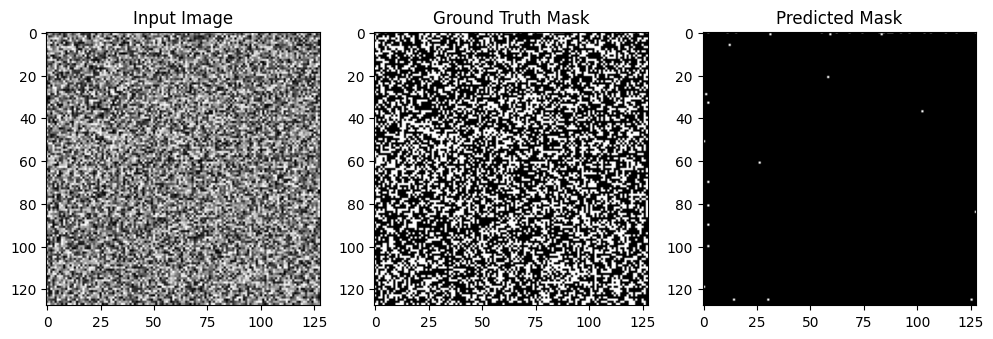

Practical 3 – U-Net segmentation completed!
Homework: Replace dummy data with real medical dataset from Kaggle.


In [ ]:
#   Step 4: Visualize results
# ────────────────────────────────────────────────
def show_prediction(idx=0):
    pred = model.predict(x_val[idx:idx+1])[0]
    pred = (pred > 0.5).astype(np.float32)

    plt.figure(figsize=(12, 4))
    plt.subplot(1,3,1); plt.imshow(x_val[idx,:,:,0], cmap='gray'); plt.title("Input Image")
    plt.subplot(1,3,2); plt.imshow(y_val[idx,:,:,0], cmap='gray'); plt.title("Ground Truth Mask")
    plt.subplot(1,3,3); plt.imshow(pred[:,:,0], cmap='gray'); plt.title("Predicted Mask")
    plt.show()

show_prediction(5)

print("Practical 3 – U-Net segmentation completed!")
print("Homework: Replace dummy data with real medical dataset from Kaggle.")





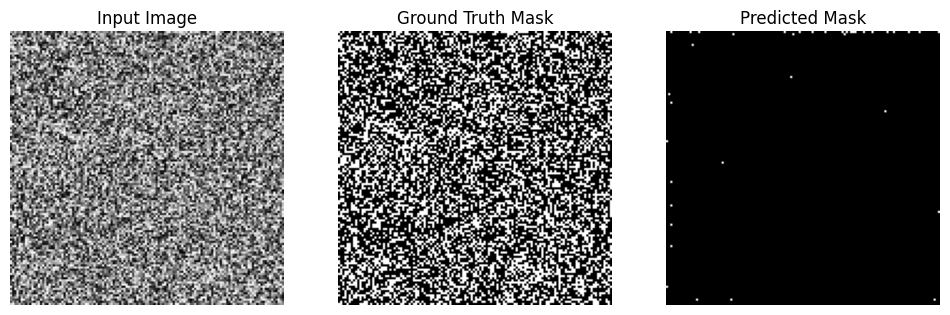

In [ ]:
#check for one image
def show_prediction(idx=0):

    # Predict single image
    pred = model.predict(x_val[idx:idx+1], verbose=0)[0]

    # Threshold to binary
    pred = (pred > 0.5).astype(np.float32)

    plt.figure(figsize=(12, 4))

    # Input
    plt.subplot(1, 3, 1)
    plt.imshow(x_val[idx, :, :, 0], cmap="gray")
    plt.title("Input Image")
    plt.axis("off")

    # Ground truth
    plt.subplot(1, 3, 2)
    plt.imshow(y_val[idx, :, :, 0], cmap="gray")
    plt.title("Ground Truth Mask")
    plt.axis("off")

    # Prediction
    plt.subplot(1, 3, 3)
    plt.imshow(pred[:, :, 0], cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()


show_prediction(5)
